# Задание 1 «Работа троллейбусов»

### Оглавление

* [Обзор данных](#Обзор-данных)
    * [Статистики по исходным данным](#Статистики-по-исходным-данным)
* [Анализ времени движения транспорта и пассажиропотока](Анализ-времени-движения-транспорта-и-пассажиропотока)
* [Итог](#Итог)

In [324]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 12, 8
plt.style.use('ggplot')

from itertools import combinations, chain, repeat

### Обзор данных

Загрузим в `DataFrame` данные, с которыми будем работать. Так же выведем на экран информацию по каждому столбцу и посмотрим на размер данных.

In [325]:
dataset = pd.read_excel('Сатистика по троллейбусам.xls')

def get_dataset_info(df: pd.DataFrame, info: bool = False, shape: bool = False) -> None:
    display(df.head())
    if info:
        df.info()
    if shape:
        print(f"\nРазмер датасета: {df.shape}") 

get_dataset_info(dataset, info=True, shape=True)

,Номер троллейбуса,Время прибытия,Количество человек
0,31,20:00:00,24
1,51,20:00:00,20
2,27,20:01:00,20
3,31,20:03:00,23
4,27,20:05:00,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
Номер троллейбуса     38 non-null int64
Время прибытия        38 non-null object
Количество человек    38 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.0+ KB

Размер датасета: (38, 3)


Признак `Время прибытия`, который `pandas` считал как `object`, явно приведем к типу `datetime`

In [326]:
dataset['Время прибытия'] = pd.to_datetime(dataset['Время прибытия'], format="%H:%M:%S")

#### Статистики по исходным данным

Рассмотрим каждую статистику ('Количество человек', 'Время прибытия' и 'Номер автобуса') подробнее

In [327]:
def get_dataset_statistics(df: pd.DataFrame) -> None:
    # Статистика по номерам троллейбуса
    print(f"Количество маршрутов троллейбусов: {len(df['Номер троллейбуса'].unique())}")
    print(f"Номера маршрутов троллейбусов: {df['Номер троллейбуса'].unique()}\n")
    
    # Статистика по времени прибытия троллейбусов
    arrival_time = df['Время прибытия']
    print(f"Раннее время прибытия: {arrival_time.min().time()}")
    print(f"Позднее время прибытия: {arrival_time.max().time()}\n")
    
    # Статистика по количеству человек
    n_people = df['Количество человек']
    print(f"Максимальное количество человек на остановке: {n_people.max()}")
    print(f"Минимальное количество человек на остановке: {n_people.min()}")
    print(f"Среднее количество человек на остановке: {round(n_people.mean())}")
    
get_dataset_statistics(dataset)

Количество маршрутов троллейбусов: 3
Номера маршрутов троллейбусов: [31 51 27]

Раннее время прибытия: 20:00:00
Позднее время прибытия: 21:00:00

Максимальное количество человек на остановке: 24
Минимальное количество человек на остановке: 3
Среднее количество человек на остановке: 13.0


__Краткий итог:__ предоставленные данные содержат информацию по станции "Дружная" за один час (20:00 - 21:00). За это время станцию посетило 38 троллейбусов, следующих по трем разным маршрутам (31, 51 и 27). Количество человек на остановке за один час колеблется в диапазоне от 3 до 24, но в среднем на остановке находится 13 человек.

### Анализ времени движения транспорта и пассажиропотока

Рассмотрим подробнее время движения троллейбусов на станции "Дружба".
Для начала посмотрим на время ожидания любого из троллейбусов на станции, затем проведем анализ времени ожидания каждого из троллейбусов по отдельности.

Добавим новые столбцы в таблицу:

    1) интервалы движения между троллейбусами (номер маршрута не важен)
    2) интервалы движения между троллейбусами соответвующих номеров

In [328]:
dataset['Интервалы троллейбусов (общие)'] = (dataset['Время прибытия'].diff() // np.timedelta64(1, 'm')).fillna(0).astype('int')
dataset['Интервалы троллейбусов (по номерам)'] = (dataset.groupby(by='Номер троллейбуса')['Время прибытия'].diff() // np.timedelta64(1, 'm')).fillna(0).astype('int')

In [329]:
dataset[['Номер троллейбуса',
         'Интервалы троллейбусов (общие)',
         'Интервалы троллейбусов (по номерам)']].head()

,Номер троллейбуса,Интервалы троллейбусов (общие),Интервалы троллейбусов (по номерам)
0,31,0,0
1,51,0,0
2,27,1,0
3,31,2,3
4,27,2,4


Визуализируем информацию о времени ожидания троллейбусов

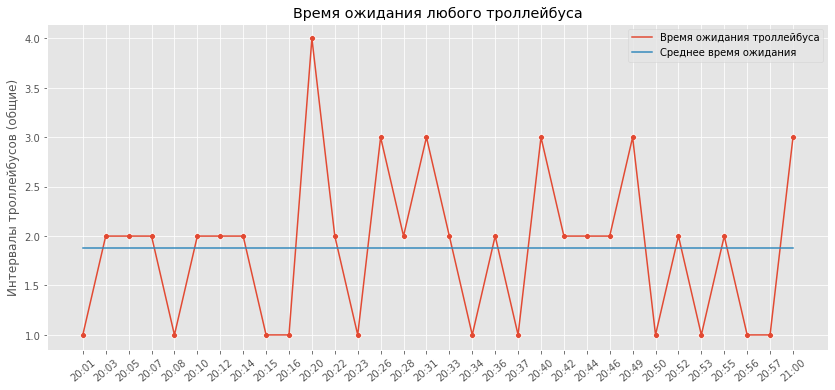

In [331]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
x = [time.strftime("%H:%M") for time in dataset['Время прибытия'].dt.time.drop_duplicates()[1:]]
y = dataset[dataset['Интервалы троллейбусов (общие)'] != 0]['Интервалы троллейбусов (общие)']
sns.lineplot(x=x, y=y, ax=ax, label="Время ожидания троллейбуса")
sns.lineplot(x=x, y=y.mean(), label="Среднее время ожидания")
sns.scatterplot(x=x, y=y, ax=ax)
ax.set_xticklabels(x, rotation=40)
ax.set_title("Время ожидания любого троллейбуса");

Как видно из графика, среднее время ожидания составляет менее двух минут, а максимальное значение достигает четырёх минут. Следовательно, время ожидания любого троллейбуса не является причиной жалобы.

__Следущее предположение:__ причиной жалобы является время ожидания любого из двух троллейбусов. Если предположение верное, то, следовательно, подтвердится гипотеза о долгом ожидании троллейбуса, следующего по одному из маршрутов.

Рассмотрим время ожидания между всеми парами троллейбусов, чтобы проверить гипотезу.

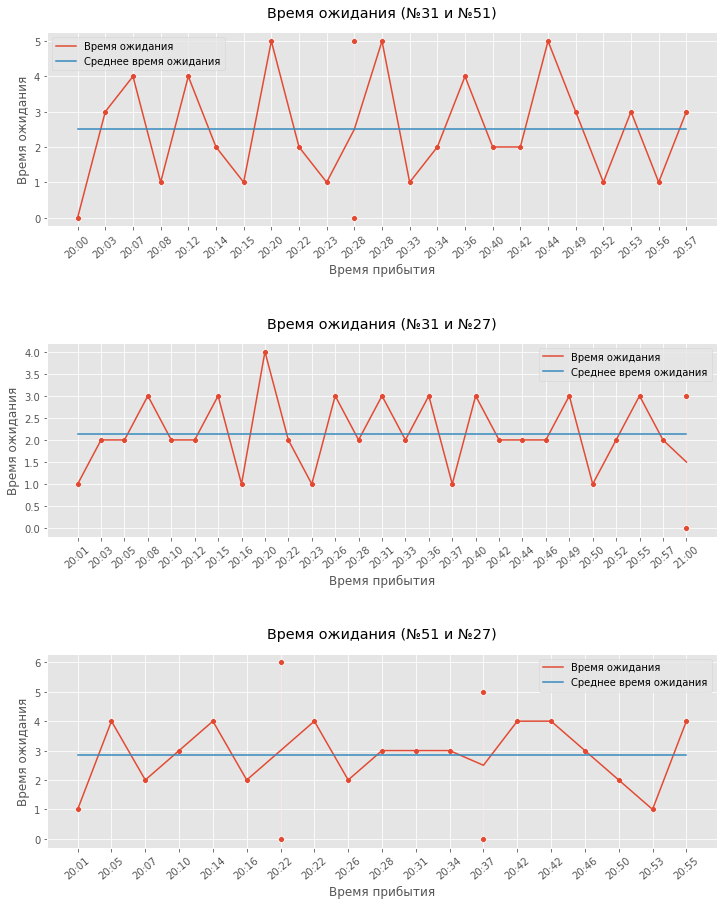

In [332]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.subplots_adjust(hspace = 0.6)
for comb, ax in zip(combinations(dataset['Номер троллейбуса'].unique(), 2), axes):
    tmp = dataset[dataset['Номер троллейбуса'].isin(comb)]
    y = (tmp['Время прибытия'].diff() // np.timedelta64(1, 'm'))[1:].astype('int')
    x = [time.strftime("%H:%M") for time in tmp['Время прибытия'].dt.time[1:]]
    sns.lineplot(x=x, y=y, ax=ax, label='Время ожидания')
    sns.lineplot(x=x, y=y.mean(), ax=ax, label='Среднее время ожидания')
    sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_xticklabels(x, rotation=40)
    ax.set(xlabel='Время прибытия', ylabel='Время ожидания')
    ax.set_title(f"Время ожидания (№{comb[0]} и №{comb[1]})", pad=15)

Предположение не подтвердилось: если человеку не важно, какой из двух троллейбусов приедет, то максимальное время ожидания составит 6 минут, а в среднем он будет тратить менее трех минут на ожидание.

Таким образом, остается рассмотреть каждый маршрут по отдельности

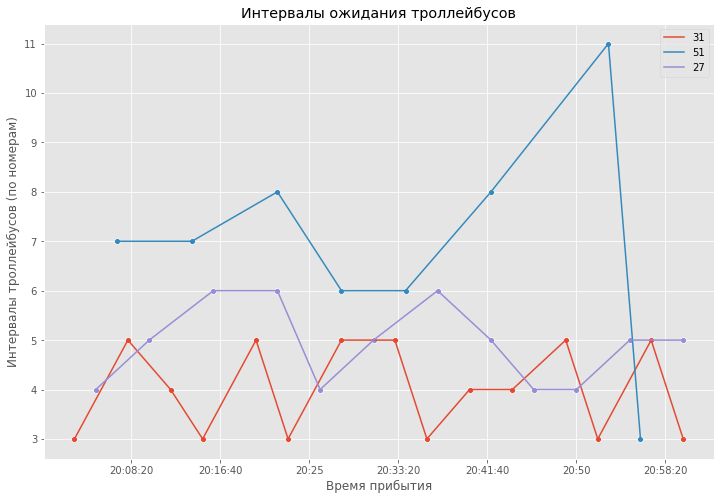

In [333]:
for n in dataset['Номер троллейбуса'].unique():
    x = dataset[dataset['Номер троллейбуса'] == n]['Время прибытия'].dt.time
    sns.lineplot(x=x, y=dataset[dataset['Номер троллейбуса'] == n]['Интервалы троллейбусов (по номерам)'][1:], label=f"{n}");
    sns.scatterplot(x=x, y=dataset[dataset['Номер троллейбуса'] == n]['Интервалы троллейбусов (по номерам)'][1:]).set_title('Интервалы ожидания троллейбусов');

Как можно заметить из графика, дольше всего приходится ожидать троллейбус №51, что, возможно, и является причиной жалобы. Уточним статистики по каждому маршруту. 

In [334]:
stat_df = pd.DataFrame(index=['Среднее значение интервала движения', 'Отклонение от среднего значения', 'Максимальное значение интервала движения'])
statistics = [np.mean, np.std, np.max]
for i, group in dataset.groupby(by='Номер троллейбуса'):
    stat_df[f'Троллейбус №{i}'] = [stat(group['Интервалы троллейбусов (по номерам)'][1:]) for stat in statistics]
stat_df.round(2)

,Троллейбус №27,Троллейбус №31,Троллейбус №51
Среднее значение интервала движения,4.92,4.00,7.00
Отклонение от среднего значения,0.76,0.89,2.12
Максимальное значение интервала движения,6.00,5.00,11.00


Самых высоких показателей по исследуемым статистикам достигает троллейбус №51. Максимальная задержка троллейбуса составляет 11 минут, что и могло послужить причной жалобы.

Далее, проанализируем пассажиропоток и добавим статистики в общую таблицу.

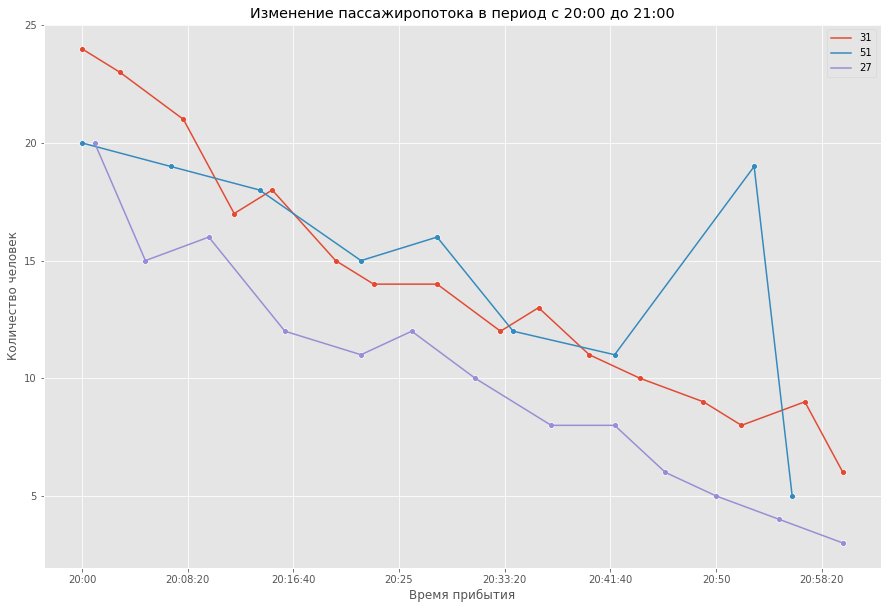

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for n in dataset['Номер троллейбуса'].unique():
    sns.lineplot(x=dataset[dataset['Номер троллейбуса'] == n]['Время прибытия'].dt.time,
                 y=dataset[dataset['Номер троллейбуса'] == n]['Количество человек'],
                 label=f'{n}', ax=ax).set_title('Количество человек на станции Дружная');
    sns.scatterplot(x=dataset[dataset['Номер троллейбуса'] == n]['Время прибытия'].dt.time,
                    y=dataset[dataset['Номер троллейбуса'] == n]['Количество человек'],
                    ax=ax);
ax.set_title('Изменение пассажиропотока в период с 20:00 до 21:00');

В целом, в данный период времени пассажиропоток имеет убывающий тренд. На графике можно видеть одно аномальное значение, связанное с маршрутом №51. В 20:53 в троллейбус зашло 19 человек. Такой же пик можно наблюдать на графике с интервалами ожидания троллейбусов, из чего можно сделать вывод, что резкое повышение количества пассажиров связано с задержкой в 11 минут.

Составим полную таблицу с параметрами, описывающими работу станции "Дружная" и подведем итог в следующем разделе (Итог).

In [336]:
passenger_df = pd.DataFrame(index=['Среднее количество человек', 'Отклонение от среднего значения кол-ва человек', 'Максимальное кол-во пассажиров'])
stats = [np.mean, np.std, np.max]
for n in dataset['Номер троллейбуса'].unique():
    passenger_df[f'Троллейбус №{n}'] = [stat(dataset[dataset['Номер троллейбуса'] == n]['Количество человек']) for stat in stats]

In [337]:
full_df = pd.concat([stat_df, passenger_df])
full_df['Все троллейбусы'] = pd.Series()
stats = [np.mean, np.mean, np.max]
for param, func in zip(full_df.index, chain.from_iterable(repeat(stats, 2))):
    full_df.loc[param, 'Все троллейбусы'] = func(full_df.loc[param, :]) 

## Итог

В ходе работы были выявлены следующие характеристики, которыми характеризуется движение транспорта и пассажиропоток.

In [338]:
full_df.round(2)

,Троллейбус №27,Троллейбус №31,Троллейбус №51,Все троллейбусы
Среднее значение интервала движения,4.92,4.00,7.00,5.31
Отклонение от среднего значения,0.76,0.89,2.12,1.26
Максимальное значение интервала движения,6.00,5.00,11.00,11.00
Среднее количество человек,10.00,14.00,15.00,13.00
Отклонение от среднего значения кол-ва человек,4.84,5.22,4.62,4.89
Максимальное кол-во пассажиров,20.00,24.00,20.00,24.00


Причиной жалобы является задержка троллейбуса, следующего по маршруту №51, на 11 минут.
Можно предположить, что в районе 20:53 на станцию "Дружба" приехал поезд (или электричка) и людям пришлось ждать троллейбус 11 минут (что является отклонением на 4 минуты от среднего времени ожидания). Во время прибытия троллейбуса, на остановке его ожидало 19 человек, в том время, как среднее количество человек на остановке в это время ~11.

Среднее время ожидания троллейбуса составляет ~5 $\pm$ 1 минут. Троллейбусов №21 и №31 имеют слабое отклонение от среднего значения (не сильно задерживаются), а также обладают равномерной загрузкой транспорта.